In [47]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

<IPython.core.display.Javascript object>

In [ ]:
# computer transition probabilities


def transition_probabilities(graph, probs, p, q):
    G = graph
    for source_node in G.nodes():
        for current_node in G.neighbors(source_node):
            probs_ = list()
            for destination in G.neighbors(current_node):
                if source_node == destination:
                    prob_ = G[current_node][destination].get("wieght", 1) * (1 / p)
                elif destination in G.neighbors(source_node):
                    prob_ = G[current_node][destination].get("weight", 1)
                else:
                    prob_ = G[current_node][destination].get("weight", 1) * (1 / q)

                probs_.append(prob_)
            probs[source_node]["probabilities"][current_node] = probs_ / np.sum(probs_)

    return probs

In [ ]:
## Baised random walk


def random_walks(graph, probs, num_walks, walk_len):
    G = graph
    walks = list()
    for start_node in G.nodes():
        for i in range(num_walks):
            walk = [start_node]
            walk_options = list(G[start_node])
            if len(walk_options) == 0:
                break
            first_step = np.random.choice(walk_options)
            walk.append(first_step)
            for k in range(walk_len - 2):
                walk_options = list(G[walk[-1]])
                if len(walk_options) == 0:
                    break
                probabilities = probs[walk[-2]]["probabilities"][walk[-1]]
                next_step = np.random.choice(walk_options, p=probabilities)
                walk.append(next_step)
            walks.append(walk)
    np.random.shuffle(walks)
    walks = [list(map(str, walk)) for walk in walks]
    return walks

In [ ]:
def training(walks, window_size, dim):
    model = Word2Vec(sentences=walks, window=window_size, vector_size=dim)

    return model.wv

In [ ]:
import numpy as np
from gensim.models import Word2Vec
import networkx as nx


class GraphEmbedding:
    """
    A class for computing node embeddings from a graph using random walks and Word2Vec.

    Args:
        graph (networkx.Graph): The input graph.
        p (float): Return parameter p for the node2vec algorithm.
        q (float): In-out parameter q for the node2vec algorithm.
        num_walks (int): Number of random walks to perform per node.
        walk_len (int): Length of each random walk.
        window_size (int): The window size for the Word2Vec model.
        dim (int): The dimensionality of the node embeddings.
        negative (int): Number of negative samples to use for negative sampling.

    Attributes:
        graph (networkx.Graph): The input graph.
        p (float): Return parameter p for the node2vec algorithm.
        q (float): In-out parameter q for the node2vec algorithm.
        num_walks (int): Number of random walks to perform per node.
        walk_len (int): Length of each random walk.
        window_size (int): The window size for the Word2Vec model.
        dim (int): The dimensionality of the node embeddings.
        negative (int): Number of negative samples to use for negative sampling.
        probs (dict): Store transition probabilities.
    """

    def __init__(self, graph, p, q, num_walks, walk_len, window_size, dim, negative):
        self.graph = graph
        self.p = p
        self.q = q
        self.num_walks = num_walks
        self.walk_len = walk_len
        self.window_size = window_size
        self.dim = dim
        self.negative = negative
        self.probs = None  # Store transition probabilities

    def transition_probabilities(self):
        """
        Compute transition probabilities for random walks on the graph.

        Returns:
            dict: A dictionary containing the transition probabilities for each node.
        """
        G = self.graph
        probs = {}

        for source_node in G.nodes():
            probs[source_node] = {"probabilities": {}}
            for current_node in G.neighbors(source_node):
                probs_ = list()
                for destination in G.neighbors(current_node):
                    if source_node == destination:
                        prob_ = G[current_node][destination].get("weight", 1) * (
                            1 / self.p
                        )
                    elif destination in G.neighbors(source_node):
                        prob_ = G[current_node][destination].get("weight", 1)
                    else:
                        prob_ = G[current_node][destination].get("weight", 1) * (
                            1 / self.q
                        )

                    probs_.append(prob_)
                probs[source_node]["probabilities"][current_node] = probs_ / np.sum(
                    probs_
                )

        self.probs = probs  # Store transition probabilities
        return probs
    

    def random_walks(self):
        """
        Generate random walks on the graph.

        Returns:
            list: A list of random walks as sequences of node IDs.
        """
        G = self.graph
        walks = list()
        num_nodes = len(G.nodes())
        S = np.zeros((num_nodes, num_nodes))  # Initialize the similarity matrix


        for start_node in G.nodes():
            for i in range(self.num_walks):
                walk = [start_node]
                walk_options = list(G[start_node])

                if len(walk_options) == 0:
                    break

                first_step = np.random.choice(walk_options)
                walk.append(first_step)

                for k in range(self.walk_len - 2):
                    walk_options = list(G[walk[-1]])

                    if len(walk_options) == 0:
                        break

                    probabilities = self.probs[walk[-2]]["probabilities"][walk[-1]]
                    next_step = np.random.choice(walk_options, p=probabilities)
                    walk.append(next_step)

                walks.append(walk)
                # Update the similarity matrix
                for node_j in G.nodes():
                    if node_j == start_node:
                        S[start_node][node_j] = 1.000  # Probability of visiting itself is 1
                    elif node_j not in walk:
                        S[start_node][node_j] = 0.000  # Probability of not visiting is 0
                    else:
                        # Calculate the probability of visiting node_j during the walk
                        prob_ij = walk.count(node_j) / (self.walk_len - 1)
                        S[start_node][node_j] += prob_ij
        np.random.shuffle(walks)
        walks = [list(map(str, walk)) for walk in walks]

        return walks, S


    def train_embedding(self, walks, dim=None, window_size=None, negative=None):
        """
        Train node embeddings using Word2Vec.

        Args:
            walks (list): List of random walks.
            dim (int, optional): The dimensionality of the node embeddings. If None, use the class's dim.
            window_size (int, optional): The window size for the Word2Vec model. If None, use the class's window_size.
            negative (int, optional): Number of negative samples to use for negative sampling.
                If None, use the class's negative value.

        Returns:
            gensim.models.keyedvectors.KeyedVectors: Trained Word2Vec model.
        """
        if dim is None:
            dim = self.dim
        if window_size is None:
            window_size = self.window_size
        if negative is None:
            negative = self.negative

        model = Word2Vec(
            sentences=walks,
            window=window_size,
            vector_size=dim,
            sg=1,
            negative=negative,
        )
        return model.wv

In [ ]:
# Define your objective function
def loss_function(params):
    (
        dimensions,
        walk_length,
        num_walks,
        p,
        q,
        learning_rate,
        window_size,
        epochs,
        negative_samples,
        batch_size,
    ) = params

    # Create and train the Node2Vec model
    node2vec_model = Node2Vec(
        G,
        int(dimensions),
        int(walk_length),
        int(num_walks),
        p,
        q,
        learning_rate,
        int(window_size),
        int(epochs),
        int(negative_samples),
    )
    node2vec_model.train(int(batch_size))
    S = node2vec_model.compute_similarity_matrix()

    # Calculate the objective function value
    embeddings = node2vec_model.get_embeddings()
    Z_transpose = np.transpose(embeddings)
    diff = np.dot(Z_transpose, embeddings) - S
    #     loss_func = np.linalg.norm(diff) ** 2
    loss_func = np.linalg.norm(diff)
    return loss_func

In [ ]:
G = nx.karate_club_graph()

In [ ]:
G

In [ ]:
# from collections import defaultdict

# probs = defaultdict(dict)


In [ ]:
# for node in G.nodes():
#     #     print(node)
#     probs[node]["probabilities"] = dict()

In [ ]:
embedding = GraphEmbedding(
    G, p=3.5, q=1.5, num_walks=10, walk_len=10, window_size=5, dim=8, negative=6
)

In [ ]:
# Compute transition probabilities
probs = embedding.transition_probabilities()

In [ ]:
probs

In [ ]:
# Generate random walks
walks, S = embedding.random_walks()

In [ ]:
walks

In [ ]:
S[0]

In [ ]:
S[1]

In [ ]:
S[33]

In [ ]:
len(walks)

In [ ]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    #     obj_func = np.linalg.norm(diff) ** 2
    obj_func = np.linalg.norm(diff)
    return obj_func

In [ ]:
los = loss_function(all_emb, S)

In [ ]:
los

In [ ]:
Z_transpose = np.transpose(all_emb)

In [ ]:
all_emb

In [ ]:
all_emb.shape

In [ ]:
S.shape

In [ ]:
# Train node embeddings using Word2Vec with custom dimensions, window size, and negative sampling
node_embeddings = embedding.train_embedding(walks, dim=20, window_size=5, negative=6)

In [ ]:
node_embeddings.

In [ ]:
all_emb = node_embeddings.vectors.T

In [ ]:
# Get the number of nodes in the graph
num_nodes = len(G.nodes())

In [ ]:
similarity_matrix[0]

In [ ]:
walks

In [ ]:
cp = transition_probabilities(G, probs, 1, 0.5)

In [ ]:
G.neighbors

In [ ]:
cp

In [ ]:
walks = random_walks(G, cp, 10, 20)


# model = Node2Vec(
#     walk_length=20, dimensions=20, p=1.0, q=0.5, window_size=20, walk_number=10
# )

In [ ]:
len(walks)

In [ ]:
walks

In [ ]:
emb = training(walks, 20, 20)

In [ ]:
myyemb = emb.vectors

In [ ]:
emb.vectors.shape

## classification 

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import torch_geometric
import torch

In [ ]:
from karateclub import Node2Vec

In [ ]:
model = Node2Vec(
    walk_length=20, dimensions=20, p=1.0, q=0.5, window_size=20, walk_number=10
)

In [ ]:
model.fit(G)

In [ ]:
embed = model.get_embedding()

In [ ]:
embed

In [ ]:
embed.shape

In [ ]:
club_labels = nx.get_node_attributes(G, "club")

In [ ]:
club_labels

In [ ]:
y = np.array(list(club_labels.values()))

In [ ]:
y

In [ ]:
y.shape

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    embed, y, test_size=0.2, random_state=42
)

In [ ]:
X_train.shape

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
y_pred

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    myyemb, y, test_size=0.2, random_state=42
)

In [ ]:
myyemb.shape

In [ ]:
logreg_d = LogisticRegression()

In [ ]:
logreg_d.fit(X_train_d, y_train_d)

In [ ]:
y_pred_d = logreg_d.predict(X_test_d)

In [ ]:
y_pred_d

In [ ]:
print(classification_report(y_test_d, y_pred_d))

In [ ]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import random
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nxa
from networkx.algorithms import community
import numpy as np
from gensim.models import Word2Vec
import networkx as nx
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "Data/"
os.makedirs(data_dir, exist_ok=True)
SEED = 42

In [ ]:
dataset = Planetoid(root=data_dir, name="Cora")
data = dataset[0]

In [ ]:
G = to_networkx(data, to_undirected=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import datetime

# Define the SkipGram model
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embedding_dim)
        self.out_embed = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target, context):
        target_embeds = self.in_embed(target)
        context_embeds = self.out_embed(context)
        scores = target_embeds @ context_embeds.t()
        return scores


In [1]:
import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [ ]:
# from node_random.randomwalk import GraphEmbedding
from node_random.pytorchwrd2vec import GraphEmbedding

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Read graph data from the file
with open('out.moreno_lesmis_lesmis', 'r') as file:
    for line in file:
        if line.startswith('%') or not line.strip():
            continue
        parts = line.split()
        if len(parts) == 3:
            node1, node2, weight = map(int, parts)
            G.add_edge(node1, node2, weight=weight)

In [44]:
# Access the weight of an edge
node1 = 2
node2 = 9
if G.has_edge(node1, node2):
    edge_data = G.get_edge_data(node1, node2)
    weight = edge_data['weight']
    print(f'The weight of the edge ({node1}, {node2}) is {weight}')
else:
    print(f'The edge ({node1}, {node2}) does not exist in the graph.')

The weight of the edge (2, 9) is 2


In [45]:
weight = G[2][9].get("weight", 1)

In [46]:
weight

2

In [29]:
aa

dict

In [7]:
from node_random.pytorchwrd2 import GraphEmbedding, SkipGram

In [8]:
G = nx.karate_club_graph()

In [4]:
# # graph, return_param, in_out_param, num_walks, walk_length, window_size, embedding_dimension, negative_samples

# Best Hyperparameters: {'return_param': 0.780188065757644, 'in_out_param': 1.0504386209768906, 
# 'num_walks': 6, 'walk_length': 11, 'window_size': 7, 'dimension': 128, 'epochs': 100, 'negative': 5, 'batch_words': 100}
# Best Loss: 62.610528542536336

In [9]:
embedding = GraphEmbedding(
    graph=G,
    return_param=2.13,
    in_out_param=0.2,
    num_walks=5,
    walk_length=5,
)

In [10]:
probab = embedding.calculate_transition_probabilities()

Calculating Transition Probabilities: 100%|██████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 6801.47it/s]


In [11]:
walks, unsh = embedding.generate_random_walks()

Generating Random Walks: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 178.91it/s]


In [ ]:
walks

In [ ]:
walks_ra = [list(map(str, walk)) for walk in walks]

In [ ]:
aa = [[1,2],[11,44]]

In [ ]:
walks_ra = [list(map(str, walk)) for walk in aa]

In [ ]:
walks_ra

In [ ]:
# {'return_param': 2.1257697440212895, 'in_out_param': 0.20047393504471897, 'num_walks': 5, 
# 'walk_length': 52, 'window_size': 8, 'dimension': 48, 'epochs': 2, 'negative': 10, 'batch_words': 500}
# Best Loss: 16319.960704831274

In [ ]:
# train_embedding(self, walks, dim=None, window_size=None, negative=None)
# training(walks, window_size, dim):
# Best Hyperparameters: {'return_param': 3.772450896108167, 'in_out_param': 1.3046561528620453, 'num_walks': 14,
# 'walk_length': 73, 'window_size': 11, 'dimension': 32, 'epochs': 2, 'negative': 10, 'batch_words': 100}

Training Word2Vec: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:36<00:00,  3.18it/s]


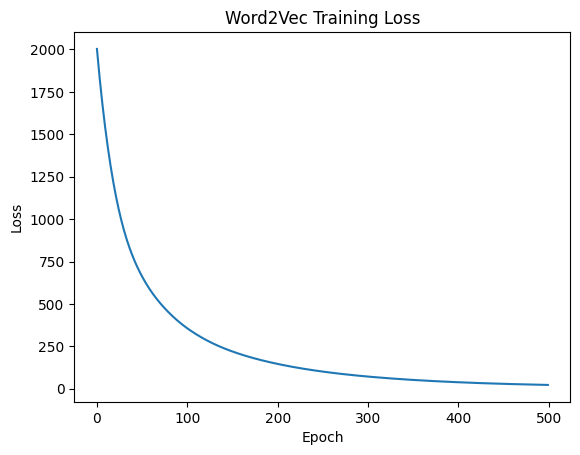

In [13]:
# Train node embeddings using Word2Vec with custom dimensions, window size, and negative sampling
# Train node embeddings using Word2Vec with custom dimensions, window size, and negative sampling
window_size = 8  # Set your desired window size
dimension = 32  # Set your desired dimension
epochs = 500
# negative=10
learning_rate = 0.001
weight_decay= 1e-5
# batch_words=500


node_embeddings = embedding.training(
#     walks, window_size=window_size, dimension=dimension, sg=1,epochs=epochs,negative=negative,batch_words=batch_words,learning_rate=learning_rate
    walks, window_size=window_size, dimension=dimension,epochs=epochs,learning_rate=learning_rate,weight_decay=weight_decay
)

In [14]:
embeddings = node_embeddings.in_embed.weight.data.numpy()

In [15]:
embeddings

array([[ 1.0870283 , -0.57400364, -0.72128594, ..., -0.36965042,
         1.1681918 ,  2.09849   ],
       [-1.7206445 ,  0.03122066,  0.37317446, ..., -0.7103805 ,
        -1.0135448 , -0.29361674],
       [ 1.0830121 ,  1.0382742 , -0.5489604 , ..., -1.5808293 ,
         0.49438465,  0.52752715],
       ...,
       [-1.0172098 ,  1.9145172 , -1.7334164 , ..., -1.4159423 ,
        -0.01724284,  0.85381186],
       [ 1.1370748 ,  0.160061  ,  0.14435835, ..., -0.6668974 ,
         0.6691276 ,  1.0659354 ],
       [-0.33354032,  0.29413125, -0.16264345, ..., -1.0298501 ,
         0.5097951 ,  1.9456618 ]], dtype=float32)

In [16]:
S= embedding.calculate_probability_matrix(unsh)

Calculating Probabilities: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2704.10it/s]


In [17]:
Z = embeddings.T

In [18]:
Z

array([[ 1.0870283 , -1.7206445 ,  1.0830121 , ..., -1.0172098 ,
         1.1370748 , -0.33354032],
       [-0.57400364,  0.03122066,  1.0382742 , ...,  1.9145172 ,
         0.160061  ,  0.29413125],
       [-0.72128594,  0.37317446, -0.5489604 , ..., -1.7334164 ,
         0.14435835, -0.16264345],
       ...,
       [-0.36965042, -0.7103805 , -1.5808293 , ..., -1.4159423 ,
        -0.6668974 , -1.0298501 ],
       [ 1.1681918 , -1.0135448 ,  0.49438465, ..., -0.01724284,
         0.6691276 ,  0.5097951 ],
       [ 2.09849   , -0.29361674,  0.52752715, ...,  0.85381186,
         1.0659354 ,  1.9456618 ]], dtype=float32)

In [19]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    #     obj_func = np.linalg.norm(diff) ** 2
    obj_func = np.linalg.norm(diff)
    return obj_func

In [20]:
loss_function(Z, S)

266.8119837224696

### Hypertuning

In [ ]:
# Define the hyperparameter search space
param_space = {
    'return_param': np.random.uniform(0.0, 4.0, 50),  # Example: random uniform sampling
    'in_out_param': np.random.uniform(0.0, 4.0, 50),  # Example: random uniform sampling
    'num_walks': np.random.randint(5, 15, 8),  # Example: random integer sampling
    'walk_length': np.random.randint(5, 15,10),  # Example: random integer sampling
    'window_size': np.random.randint(5, 10, 5),  # Example: random integer sampling
    'dimension': np.random.choice([2,4,6,8,10], 6),  # Example: random choice
    'epochs': np.random.choice([100, 150,200,125,300], 5),  # Example: random choice
    'negative': np.random.choice([3, 6], 5),  # Example: random choice
    'batch_words': np.random.choice([8, 16], 5),  # Example: random choice
    'learning_rate': np.random.choice([0.01, 0.0001, 0.02],10),
    'min_count': np.random.choice([0, 1,2], 6),
}

best_loss = float('inf')
best_params = None

In [ ]:
# Perform random search
num_iterations = 20  # Adjust the number of iterations as needed


In [ ]:
for _ in range(num_iterations):
    # Randomly sample hyperparameters
    sampled_params = {param: np.random.choice(values) for param, values in param_space.items()}
    
    # Create an instance of your GraphEmbedding class with sampled hyperparameters
    embedding = GraphEmbedding(
        graph=G,
        return_param=sampled_params['return_param'],
        in_out_param=sampled_params['in_out_param'],
        num_walks=sampled_params['num_walks'],
        walk_length=sampled_params['walk_length'],
    )
    
    probab = embedding.calculate_transition_probabilities()
    # Train and evaluate with the current set of hyperparameters
    walks, uns = embedding.generate_random_walks()
    S = embedding.calculate_probability_matrix(uns)
    node_embeddings = embedding.training(
        walks,
        window_size=sampled_params['window_size'],
        dimension=sampled_params['dimension'],
        sg=1,
        epochs=sampled_params['epochs'],
        negative=sampled_params['negative'],
        batch_words=sampled_params['batch_words'],
        learning_rate = sampled_params['learning_rate']
    )
    Z = node_embeddings.vectors.T
    current_loss = loss_function(Z, S)
    
    # Update the best hyperparameters if the current set is better
    if current_loss < best_loss:
        best_loss = current_loss
        best_params = sampled_params

In [ ]:
S.shape

In [ ]:
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)